In [1]:
from typing import Optional

import pandas as pd
from src.utils.path_utils import get_project_root

PROJECT_ROOT = get_project_root()

In [2]:
from src.utils.data_utils import get_preprocessed_data

factify_test = get_preprocessed_data("test")
factify_train = get_preprocessed_data("train")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from src.utils.data_utils import get_preprocessed_data
from typing import Optional

# Fix randomness for consistent language detection results
DetectorFactory.seed = 0


def detect_language(text: str) -> str:
    """
    Detect the language of a given text.

    Args:
        text (str): The input text.

    Returns:
        str: The detected language code or 'unknown' if detection fails.
    """
    try:
        if pd.isna(text) or not text.strip():
            return "unknown"
        return detect(text)
    except LangDetectException:
        return "unknown"


def analyze_dataset(dataset_name: Optional[str] = None, dataset: Optional[pd.DataFrame] = None):
    """
    Analyze the specified dataset (train or test) for relevant statistics and language distributions.

    Args:
        dataset_name (str): The name of the dataset ('train' or 'test').
        dataset (pd.DataFrame): The preprocessed dataset DataFrame. If not provided, the dataset will be loaded.
    """
    # Load the dataset
    if not dataset:
        dataset = get_preprocessed_data(dataset_name)

    print(f"Analyzing {dataset_name} dataset...\n")

    # 1. General Dataset Statistics
    print("Dataset Overview:")
    print(f"Number of rows: {dataset.shape[0]}")
    print(f"Columns: {', '.join(dataset.columns)}")

    # Count rows with valid images
    claim_image_count = dataset["claim_image"].notna().sum()
    evidence_image_count = dataset["evidence_image"].notna().sum()
    print(f"Rows with claim images: {claim_image_count}")
    print(f"Rows with evidence images: {evidence_image_count}")

    # Distribution of categories
    print("\nCategory Distribution:")
    category_counts = dataset["category"].value_counts()
    print(category_counts)

    # 2. Image Availability by Category
    image_availability = dataset.groupby("category").agg(
        total=("id", "count"),
        claim_images=("claim_image", lambda x: x.notna().sum()),
        evidence_images=("evidence_image", lambda x: x.notna().sum()),
    )
    image_availability["claim_image_percentage"] = (
        image_availability["claim_images"] / image_availability["total"] * 100
    )
    image_availability["evidence_image_percentage"] = (
        image_availability["evidence_images"] / image_availability["total"] * 100
    )
    print("\nImage Availability by Category:")
    print(image_availability)

    # 3. Text Length Statistics
    for column in ["claim", "claim_ocr", "evidence", "evidence_ocr"]:
        dataset[f"{column}_length"] = dataset[column].fillna("").apply(len)

    text_length_stats = dataset[[f"{col}_length" for col in ["claim", "claim_ocr", "evidence", "evidence_ocr"]]].describe()
    print("\nText Length Statistics:")
    print(text_length_stats)

    # 4. Multimodal Coverage
    multimodal_coverage = dataset[["claim_image", "evidence_image"]].notna().all(axis=1).sum()
    multimodal_coverage_percentage = multimodal_coverage / len(dataset) * 100

    print("\nMultimodal Coverage:")
    print(f"Rows with both claim and evidence images: {multimodal_coverage}")
    print(f"Percentage of rows with multimodal data: {multimodal_coverage_percentage:.2f}%")

    # 5. OCR vs. Original Text Analysis
    dataset["claim_vs_claim_ocr_diff"] = dataset["claim"].fillna("").apply(len) - dataset["claim_ocr"].fillna("").apply(len)
    dataset["evidence_vs_evidence_ocr_diff"] = dataset["evidence"].fillna("").apply(len) - dataset["evidence_ocr"].fillna("").apply(len)

    print("\nOCR vs. Original Text Length Difference:")
    ocr_diff_stats = dataset[["claim_vs_claim_ocr_diff", "evidence_vs_evidence_ocr_diff"]].describe()
    print(ocr_diff_stats)

    # 6. Language Detection
    print("\nDetecting languages...")
    for column in ["claim", "claim_ocr", "evidence", "evidence_ocr"]:
        lang_col = f"{column}_language"
        dataset[lang_col] = dataset[column].fillna("").apply(detect_language)

    # Language Stats
    print("\nLanguage Statistics:")
    language_columns = [f"{col}_language" for col in ["claim", "claim_ocr", "evidence", "evidence_ocr"]]
    for lang_col in language_columns:
        print(f"\nLanguage distribution for {lang_col.replace('_language', '')}:")
        lang_counts = dataset[lang_col].value_counts()
        print(lang_counts)

    # Visualize Category Distribution
    print("\nGenerating visualizations...")
    category_counts.plot(kind="bar", figsize=(10, 6), title=f"{dataset_name.capitalize()} Category Distribution")
    plt.xlabel("Category")
    plt.ylabel("Number of Samples")
    plt.show()

    # Visualize Image Availability
    image_availability[["claim_image_percentage", "evidence_image_percentage"]].plot(kind="bar", figsize=(10, 6))
    plt.title(f"{dataset_name.capitalize()} Image Availability by Category")
    plt.ylabel("Percentage")
    plt.xlabel("Category")
    plt.legend(["Claim Images", "Evidence Images"])
    plt.show()

    # Visualize Language Distribution
    for lang_col in language_columns:
        lang_counts = dataset[lang_col].value_counts()
        lang_counts.plot(kind="bar", figsize=(10, 6), title=f"{dataset_name.capitalize()} {lang_col.replace('_language', '').capitalize()} Language Distribution")
        plt.xlabel("Language")
        plt.ylabel("Number of Samples")
        plt.show()

    print(f"Analysis for {dataset_name} dataset completed.\n")

Analyzing test dataset...

Dataset Overview:
Number of rows: 7500
Columns: id, claim, claim_image_original, evidence, evidence_image_original, category, claim_ocr, evidence_ocr, claim_image, evidence_image
Rows with claim images: 6954
Rows with evidence images: 6350

Category Distribution:
category
Refute                     1500
Support_Multimodal         1500
Support_Text               1500
Insufficient_Multimodal    1500
Insufficient_Text          1500
Name: count, dtype: int64

Image Availability by Category:
                         total  claim_images  evidence_images  \
category                                                        
Insufficient_Multimodal   1500          1500             1500   
Insufficient_Text         1500          1494             1492   
Refute                    1500           980              372   
Support_Multimodal        1500          1496             1498   
Support_Text              1500          1484             1488   

                         

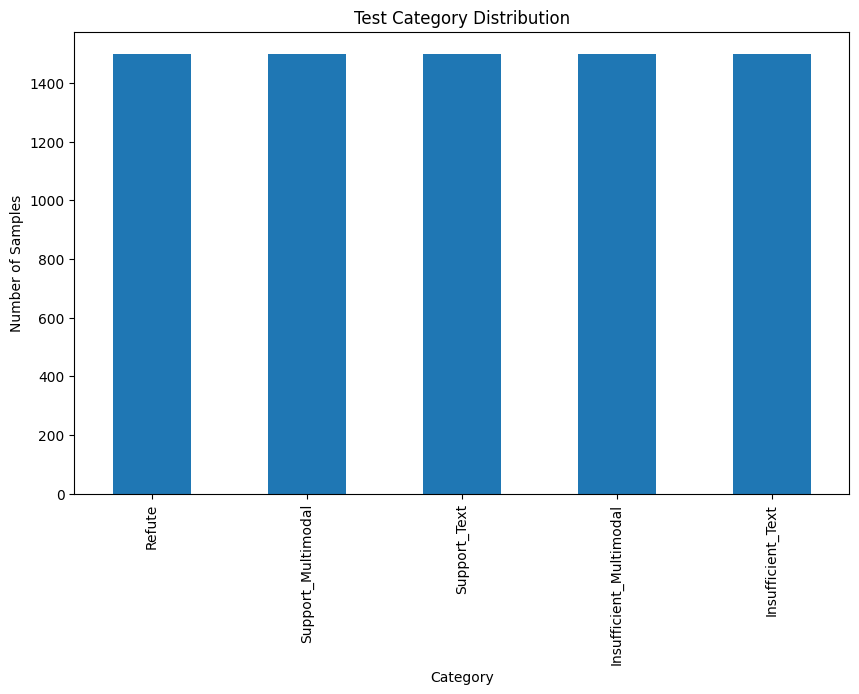

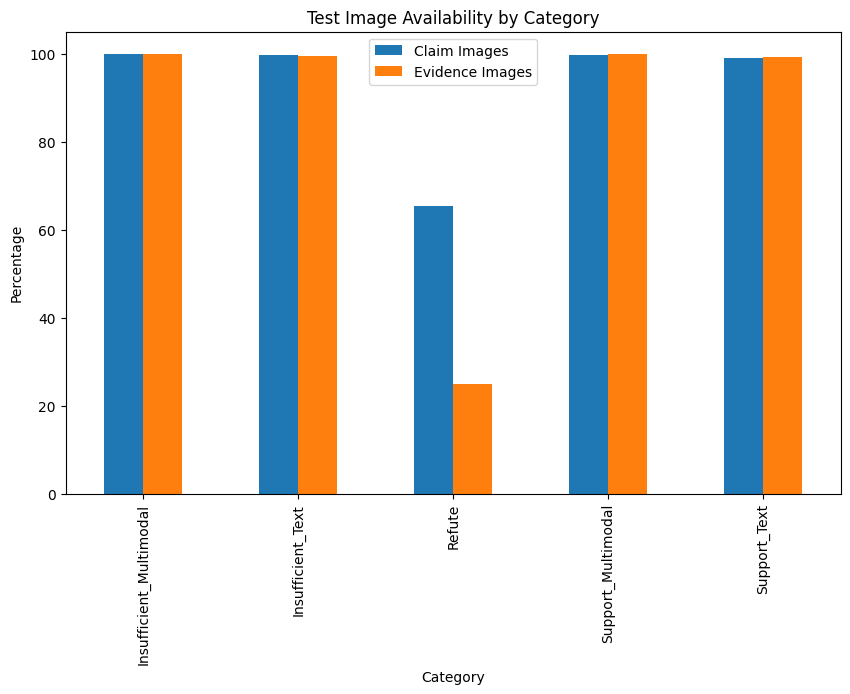

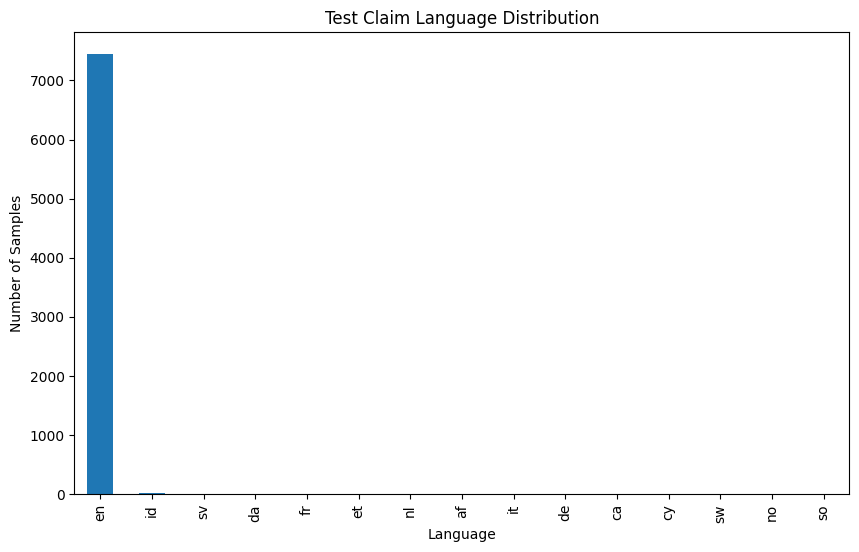

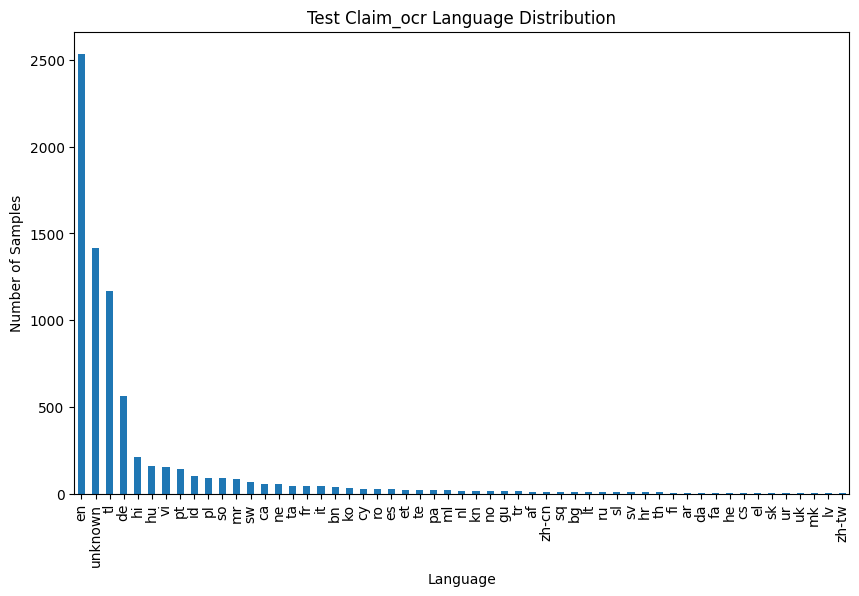

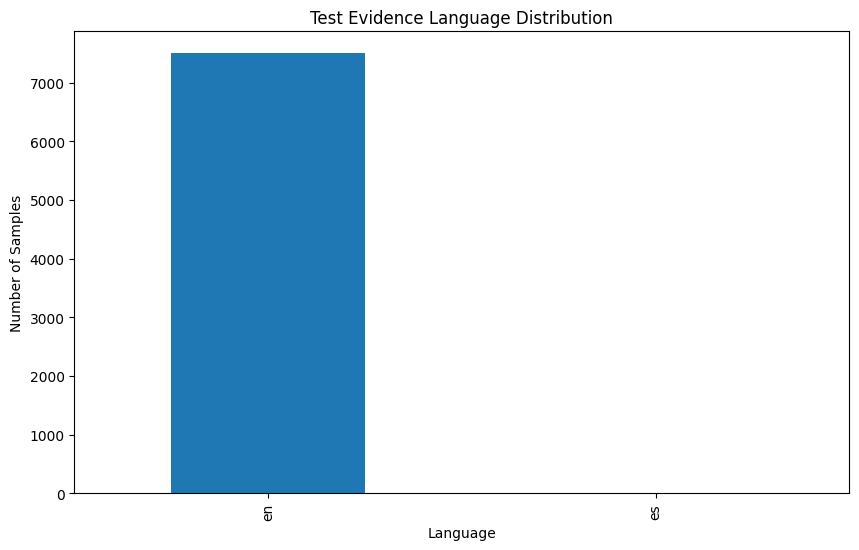

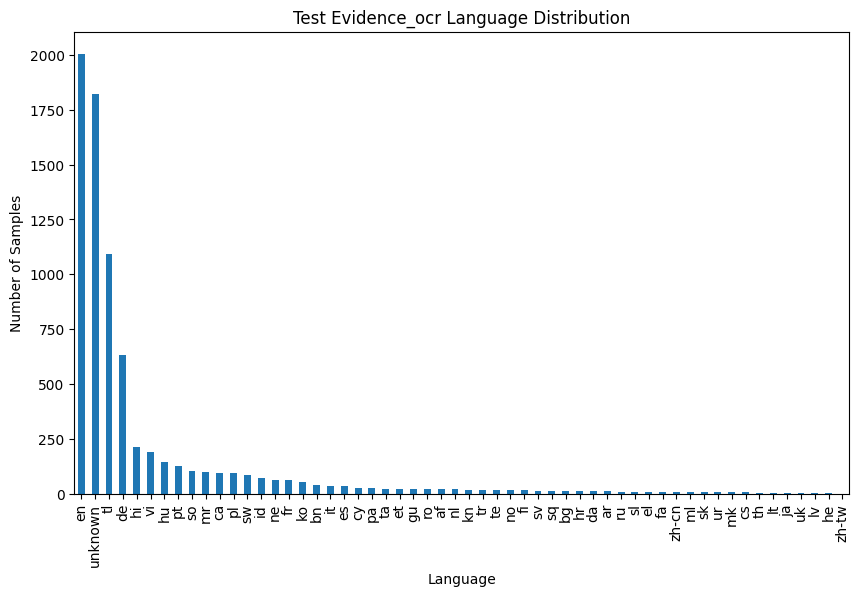

Analysis for test dataset completed.



In [4]:
analyze_dataset("test")

Analyzing train dataset...

Dataset Overview:
Number of rows: 35000
Columns: id, claim, claim_image_original, evidence, evidence_image_original, category, claim_ocr, evidence_ocr, claim_image, evidence_image
Rows with claim images: 34685
Rows with evidence images: 34906

Category Distribution:
category
Support_Multimodal         7000
Insufficient_Multimodal    7000
Support_Text               7000
Refute                     7000
Insufficient_Text          7000
Name: count, dtype: int64

Image Availability by Category:
                         total  claim_images  evidence_images  \
category                                                        
Insufficient_Multimodal   7000          6997             6994   
Insufficient_Text         7000          6981             6976   
Refute                    7000          6772             6995   
Support_Multimodal        7000          6990             6987   
Support_Text              7000          6945             6954   

                     

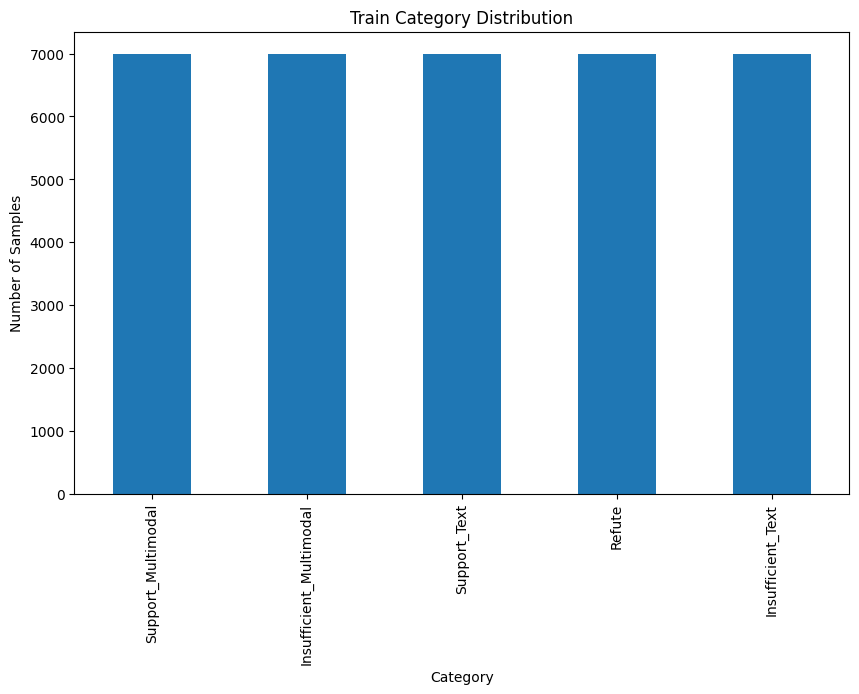

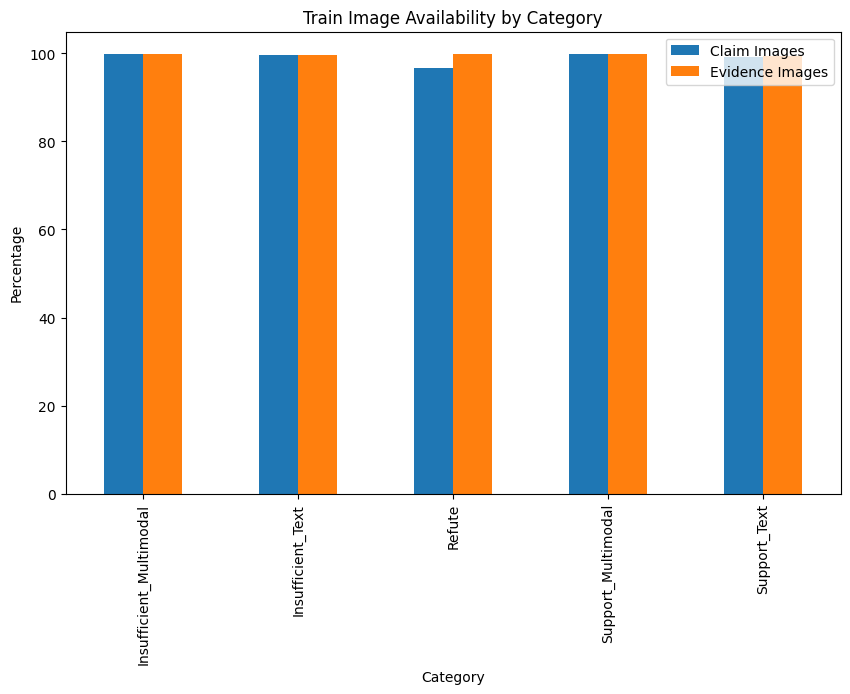

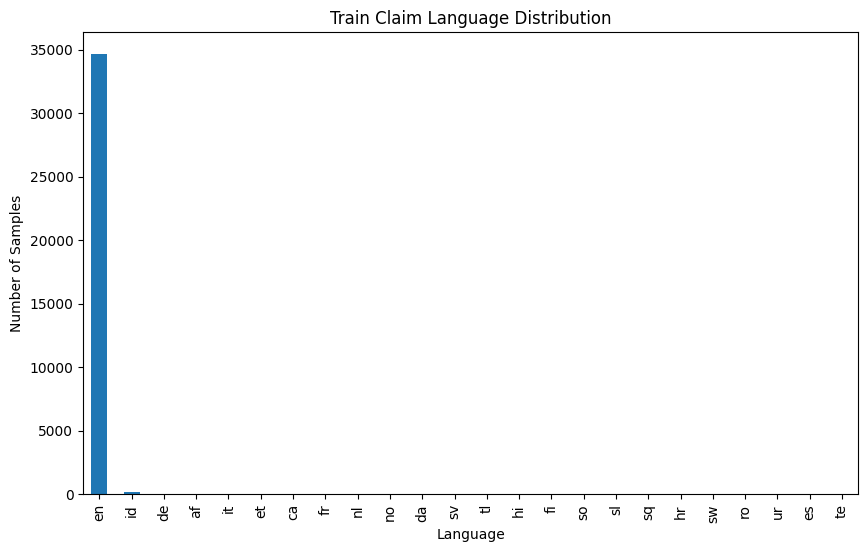

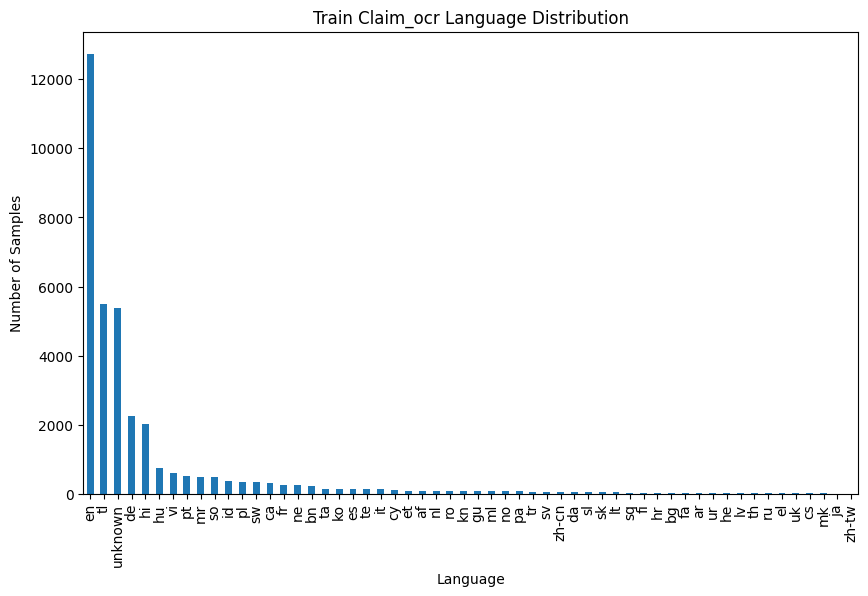

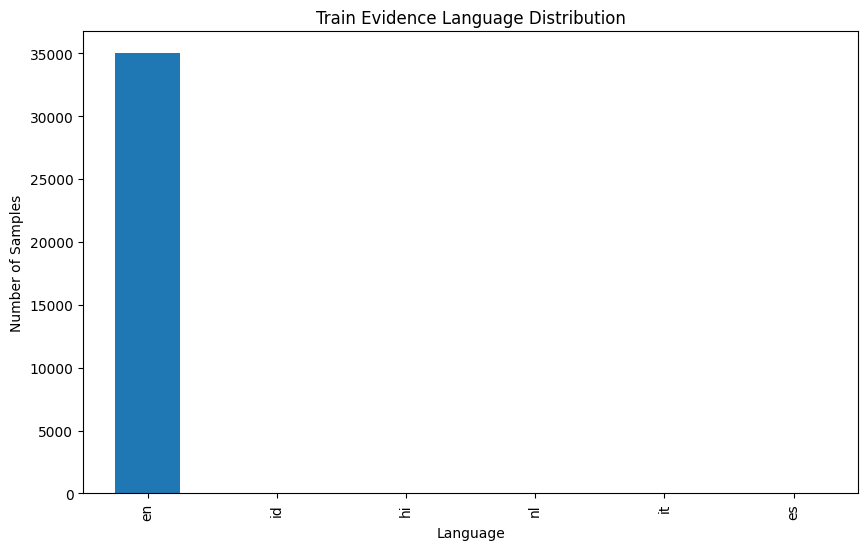

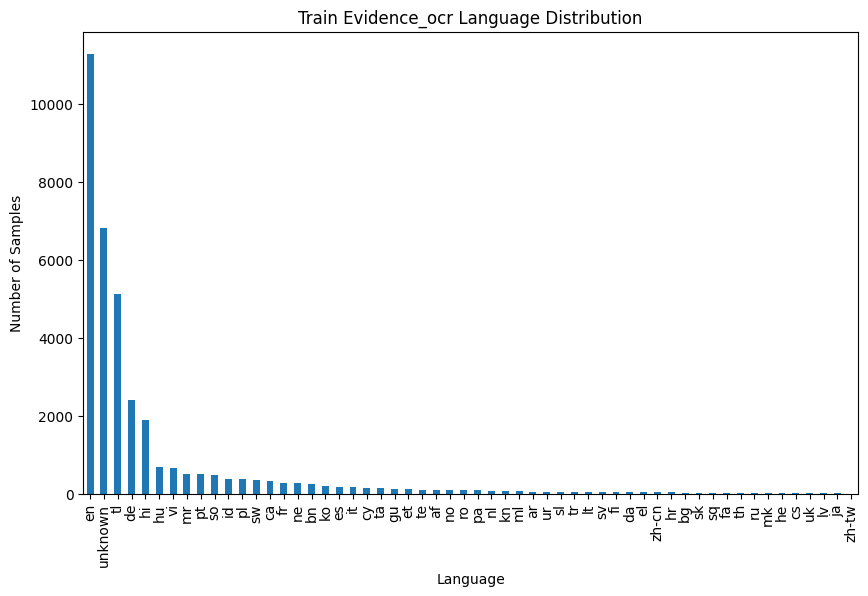

Analysis for train dataset completed.



In [5]:
analyze_dataset("train")